In [1]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:3


In [2]:
source_path = '../data/OpenEphys_data/2019-04-10_14-02-35/'

In [3]:
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
f_names = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*CH(\d|\d\d)\.continuous$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][2:]) for f in f_names]
f_names = f_names[np.argsort(chans)] # now sorted by channel number

In [6]:
chan_data = []
for contact in range(7):
    contact_reps = []
    for i in range(contact*4, contact*4 + 4):
        print('Reading {}...'.format(f_names[i]))
        file_content = OpenEphys.load(f_names[i])
        Fs = float(file_content['header']['sampleRate'])
        signal_filtered = butter_bandpass_filter(file_content['data'], 100, 10000, Fs, order=2 )
        contact_reps.append(signal_filtered)
    contact_reps = np.array(contact_reps)
    chan_data.append(np.mean(contact_reps, axis=0))
    print('-----------------------------------------------')
chan_data = np.array(chan_data)
contact_reps = None

Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH1.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH2.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH3.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH4.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH5.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH6.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH7.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH8.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH9.continuous...
Loading continuous data...
Read

In [7]:
common_avg_ref(chan_data)
chan_data = scipy.signal.detrend(chan_data)

chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
print('Saving filtered data to {}'.format(chan_filtered_fname))
np.save(chan_filtered_fname, chan_data)

MemoryError: 

In [6]:
chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
chan_data = np.load(chan_filtered_fname)
Fs = 30000.0

### Plot channel voltage

In [14]:
chan_data.shape

(7, 77221888)

<IPython.core.display.Javascript object>


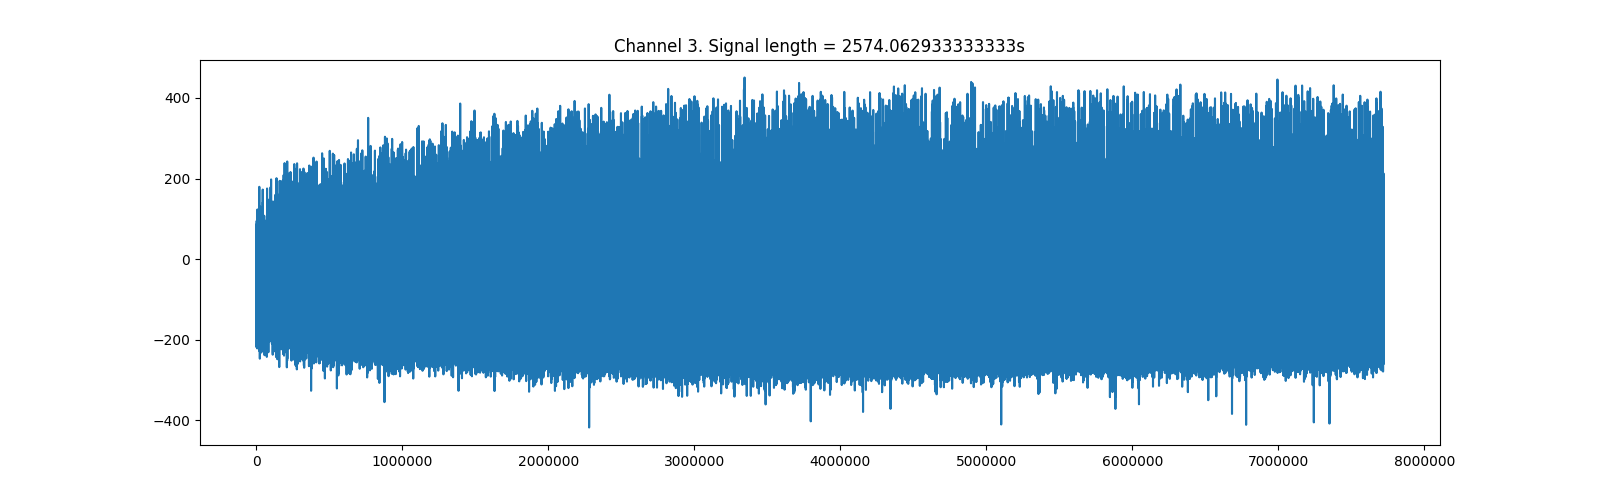

Text(0.5, 1.0, 'Channel 3. Signal length = 2574.062933333333s')

In [46]:
# plot channel
plt.figure(figsize=(16,5))
plt.plot(chan_data[chan_index,::10])
plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

In [22]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
css.num_gmm_components = 3
css._init_gmm()
css._pre_process()
css._detect_spikes_minibatch(use_filtered=False, select_clust = 'min', align_to='min')
# print(css.cs_indices.shape)

Using minibatch spike detection, batch size = 50s
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not d

AttributeError: 'ComplexSpikeSorter' object has no attribute 'cs_indices'

In [23]:
css._align_spikes(remove_align_overlaps=False)

# css.run(use_filtered=False)
# print(css.cs_indices.shape)

css._cluster_spike_by_feature(remove_overlaps=False)

css.cs_indices.shape

Using all spikes for alignment (no overlap removal)


(3011,)

In [41]:
orig_cs_idnices = css.cs_indices
css.cs_indices = css._remove_overlapping_complex_spikes()


Merging overlapping CS waveforms


In [40]:
css.cs_indices = orig_cs_idnices

In [43]:
num_clusters = 4
pre_time = 0.0005
post_time = 0.005
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time, align_to='min')
ss_indices = css.get_ss_indices()

In [28]:
ss_indices.shape

(124944,)

In [44]:
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

In [ ]:
t1 = time.time()
print('Total run time = {} s'.format(t1-t0))

<IPython.core.display.Javascript object>


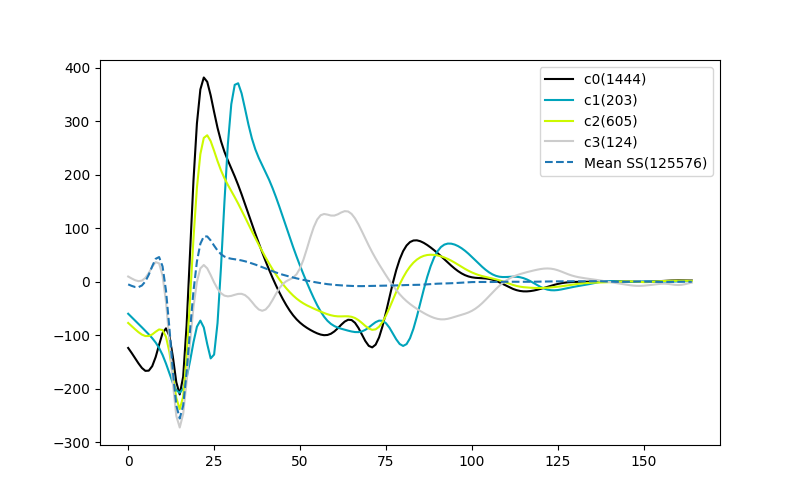

In [45]:
# plot cluster means
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
plt.legend() 

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

In [ ]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

In [ ]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

## Saving detected CS and SS:

In [ ]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(chan_data_raw[chan_index,:], alpha = 0.5)
plt.plot(chan_data[chan_index,:], alpha = 0.8)
plt.eventplot(cs_indices, linelengths=300, colors='r', alpha=0.4)
